In [1]:
!git clone https://github.com/shobhit5090/Informer

Cloning into 'Informer'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 67 (delta 1), reused 0 (delta 0), pack-reused 61
Receiving objects: 100% (67/67), 6.07 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
%cd /content/Informer/Informer2020-main

/content/informer/Informer2020-main


# Training,Testing and Prediction using Two models on ETTh1 Dataset
-a : prediction length of 24 to compare with table-1 result in the given paper
 #-b: prediction length of 240

In [ ]:
!python -u main_informer.py --model informer --data ETTh1 --attn prob --freq h --do_predict --pred_len 24 --features S

Args in experiment:
Namespace(model='informer', data='ETTh1', root_path='./data/ETT/', data_path='ETTh1.csv', features='S', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=24, enc_in=1, dec_in=1, c_out=1, d_model=512, n_heads=8, e_layers=2, d_layers=1, s_layers=[3, 2, 1], d_ff=2048, factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=True, mix=True, cols=None, num_workers=0, itr=2, train_epochs=6, batch_size=32, patience=3, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='h')
Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.1422525
	speed: 0.1563s/iter; left time: 233.9800s
	iters:

In [ ]:
!python -u main_informer.py --model informer --data ETTh1 --attn prob --freq h --do_predict --pred_len 240 --features S

Args in experiment:
Namespace(model='informer', data='ETTh1', root_path='./data/ETT/', data_path='ETTh1.csv', features='S', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=240, enc_in=1, dec_in=1, c_out=1, d_model=512, n_heads=8, e_layers=2, d_layers=1, s_layers=[3, 2, 1], d_ff=2048, factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=True, mix=True, cols=None, num_workers=0, itr=2, train_epochs=6, batch_size=32, patience=3, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='h')
Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftS_sl96_ll48_pl240_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8305
val 2641
test 2641
	iters: 100, epoch: 1 | loss: 0.1875251
	speed: 0.1572s/iter; left time: 228.7509s
	iter


# Test-0

In [ ]:
import numpy as np

prediction_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/real_prediction.npy')

prediction_0.shape

(1, 24, 1)

In [ ]:
# here is the detailed code of function predict
import torch

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')

    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()

    preds = []

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)

        pred = outputs.detach().cpu().numpy()#.squeeze()

        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    np.save(folder_path+'real_prediction.npy', preds)

    return preds


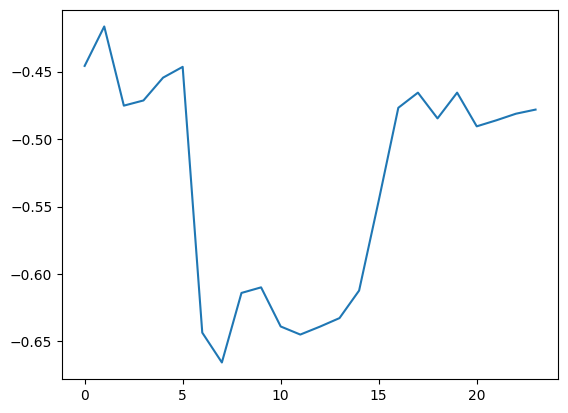

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction_0[0,:,-1])
plt.show()

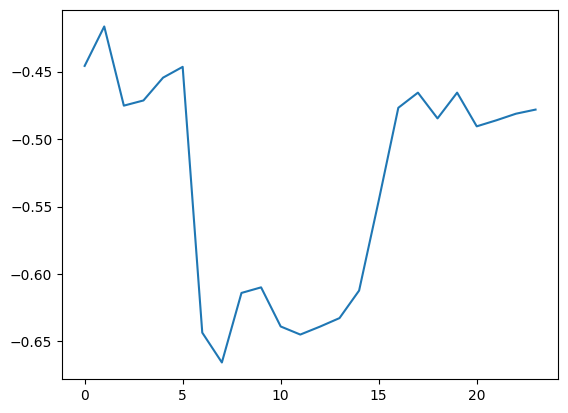

In [ ]:
setting = 'informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0'
prediction_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/real_prediction.npy')

plt.figure()
plt.plot(prediction_0[0,:,-1])
plt.show()

In [ ]:
preds_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/pred.npy')
trues_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/true.npy')
preds_0.shape,trues_0.shape

((2848, 24, 1), (2848, 24, 1))

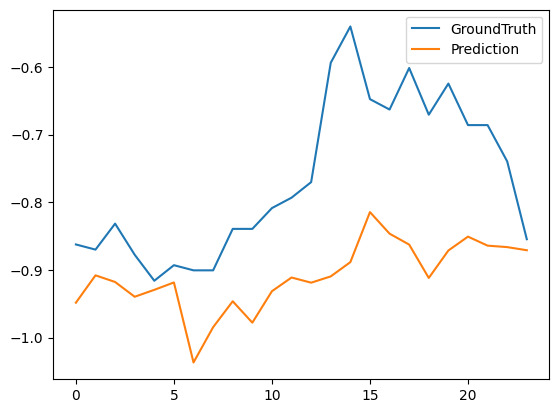

In [ ]:
preds_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/pred.npy')
trues_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/true.npy')
preds_0.shape,trues_0.shape

plt.figure()
plt.plot(trues_0[0,:,-1], label='GroundTruth')
plt.plot(preds_0[0,:,-1], label='Prediction')
plt.legend()
plt.show()

### **Test-1**

In [ ]:

prediction_1 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1/real_prediction.npy')

prediction_1.shape

(1, 24, 1)

In [ ]:
# here is the detailed code of function predict
import torch

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')

    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()

    preds = []

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)

        pred = outputs.detach().cpu().numpy()#.squeeze()

        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    np.save(folder_path+'real_prediction.npy', preds)

    return preds


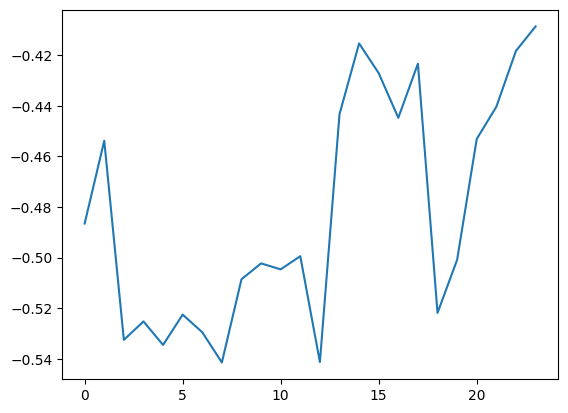

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction_1[0,:,-1])
plt.show()

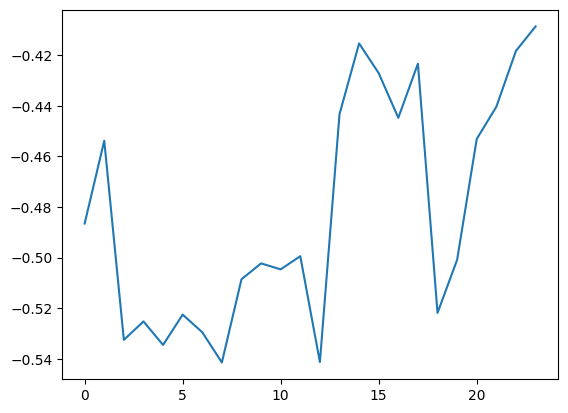

In [ ]:
setting = '/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1'
prediction_0 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1/real_prediction.npy')

plt.figure()
plt.plot(prediction_0[0,:,-1])
plt.show()

In [ ]:
preds_1 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1/pred.npy')
trues_1 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1/true.npy')
preds_1.shape,trues_1.shape

((2848, 24, 1), (2848, 24, 1))

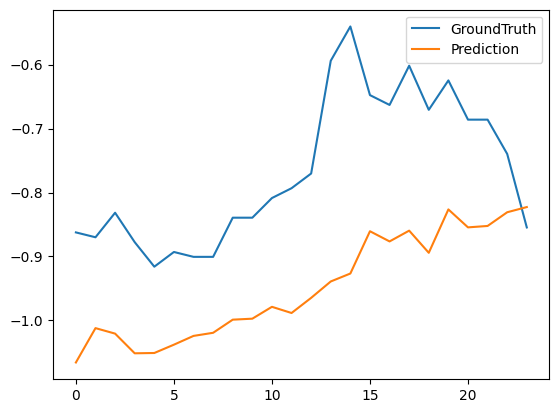

In [ ]:
preds_1 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1/pred.npy')
trues_1 = np.load('/content/Informer/Informer2020-main/results/informer_ETTh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1/true.npy')
preds_1.shape,trues_1.shape

plt.figure()
plt.plot(trues_1[0,:,-1], label='GroundTruth')
plt.plot(preds_1[0,:,-1], label='Prediction')
plt.legend()
plt.show()